# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('/datasets/autos.csv')

### Проверка данных

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


#### Пропуски

In [6]:
# приведем к нижнему регистру столбцы

data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

/tmp/ipykernel_180/3291007425.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

##### Поиск

In [8]:
def get_pass_data_frame(data):
    try:
        return (
            data.isnull().sum().sort_values()
            .to_frame()
            .rename(columns = {0: 'space'})
            .query('space > 0')
        )
        
    except:
        print('пропусков не осталось :) ')

In [9]:
pass_data_frame = get_pass_data_frame(data)

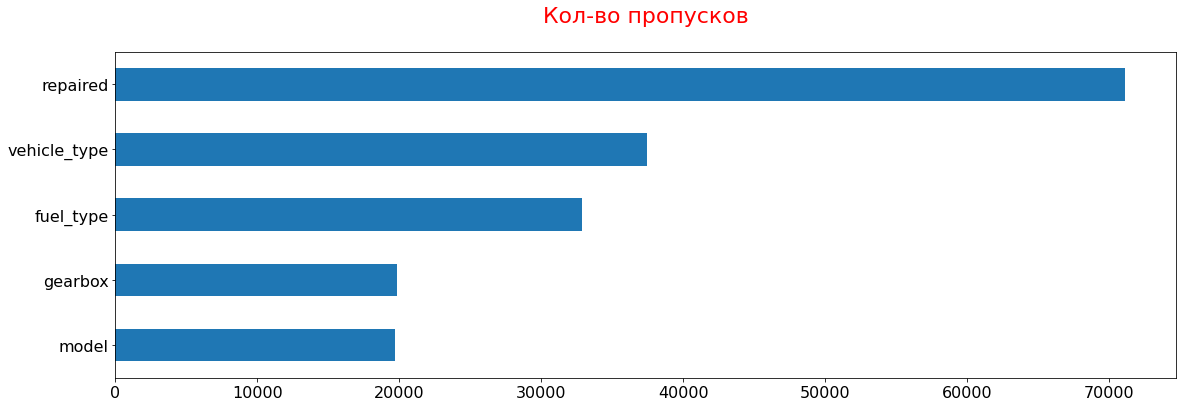

In [10]:
pass_data_frame.plot(
    kind='barh', figsize=(19, 6), legend=False, fontsize=16).set_title(
    'Кол-во пропусков' + "\n", fontsize=22, color='Red');

**Вывод по графику**

- Самое большое кол-во пропусков в Repaired (была машина в ремонте или нет), далее в VehicleType (тип кузова), на 3м месте FuelType (тип топлива), после чего Gearbox (тип коробки передач) и завешает Model (модель авто)

- Всего данных 354369, в столбцах, представленных на графике, 5-20% пропусков.

##### Заполнение и удаление

In [11]:
# check

data['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [12]:
# check

data['model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [13]:
# check

data['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [14]:
# check

data['repaired'].value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

In [15]:
# заполняем пропуски в gearbox, model, fuel_type, repaired

data.fillna({'gearbox':'manual', 'model':'other', 'fuel_type': 'other', 'repaired': 'unknown'}, inplace=True)

In [16]:
# разберемся с vehicle_type

data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [17]:
data['vehicle_type'] = data['vehicle_type'].fillna(data.groupby('model')['vehicle_type'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else "unknown"))

In [18]:
data["vehicle_type"].isnull().sum()

0

In [19]:
data["vehicle_type"]

0               sedan
1               coupe
2                 suv
3               small
4               small
             ...     
354364          sedan
354365          sedan
354366    convertible
354367            bus
354368          wagon
Name: vehicle_type, Length: 354369, dtype: object

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Пропусков не осталось

#### Аномалии

In [21]:
# посмотрим квантили DateCrawled, чтобы ответить на вопрос)

In [22]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'])

In [23]:
data['date_crawled'].head()

0   2016-03-24 11:52:17
1   2016-03-24 10:58:45
2   2016-03-14 12:52:21
3   2016-03-17 16:54:04
4   2016-03-31 17:25:20
Name: date_crawled, dtype: datetime64[ns]

In [24]:
data['date_crawled'].astype('int64').quantile([.25,.5,.99]).astype('datetime64[ns]')

0.25   2016-03-13 11:52:33.000
0.50   2016-03-21 17:50:55.000
0.99   2016-04-05 11:38:12.320
Name: date_crawled, dtype: datetime64[ns]

In [25]:
# отфильтруем данные, чтобы убрать выбросы

data = data.query('50 < price')
data = data.query('1930 < registration_year < 2017')
data = data.query('5 < power < 700')

In [26]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,305720.000000,305720.000000,305720.000000,305720.000000,305720.000000,305720.0,305720.000000
mean,4827.069037,2003.314376,120.335222,128467.486589,5.968893,0.0,51161.210156
std,4587.008517,6.915190,53.930012,36647.130412,3.597549,0.0,25764.523124
min,55.000000,1931.000000,6.000000,5000.000000,0.000000,0.0,1067.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30916.000000
50%,3150.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50170.000000
75%,6950.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,71717.000000
max,20000.000000,2019.000000,696.000000,150000.000000,12.000000,0.0,99998.000000


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305720 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        305720 non-null  datetime64[ns]
 1   price               305720 non-null  int64         
 2   vehicle_type        305720 non-null  object        
 3   registration_year   305720 non-null  int64         
 4   gearbox             305720 non-null  object        
 5   power               305720 non-null  int64         
 6   model               305720 non-null  object        
 7   kilometer           305720 non-null  int64         
 8   registration_month  305720 non-null  int64         
 9   fuel_type           305720 non-null  object        
 10  brand               305720 non-null  object        
 11  repaired            305720 non-null  object        
 12  date_created        305720 non-null  object        
 13  number_of_pictures  305720 no

Убрала редковстречающиеся данные и выбросы

В итоге удалены 14% данных

#### Неинформативные признаки

Считаю эти признаки неинфомативными, так как они не имеют отноения к цене авто:

- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- RegistrationMonth — месяц регистрации автомобиля
- DateCrawled — дата скачивания анкеты из базы

In [28]:
# удаляем их

data = data.drop(
    ['date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'registration_month', 'date_crawled'], 
    axis=1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305720 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              305720 non-null  int64 
 1   vehicle_type       305720 non-null  object
 2   registration_year  305720 non-null  int64 
 3   gearbox            305720 non-null  object
 4   power              305720 non-null  int64 
 5   model              305720 non-null  object
 6   kilometer          305720 non-null  int64 
 7   fuel_type          305720 non-null  object
 8   brand              305720 non-null  object
 9   repaired           305720 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.7+ MB


### Выборки для обучения моделей

In [30]:
# преобразуем категориальные признаки в численные

data_ohe = pd.get_dummies(data, drop_first=True)

In [32]:
# Делим на выборки

features_train, features_valid, target_train, target_valid = train_test_split(
    data_ohe.drop('price', axis=1), data_ohe.price, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [33]:
features_train

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
168812,2014,99,20000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
275462,1998,170,150000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
258658,2006,116,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
304720,2007,190,125000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
302978,2006,200,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184071,2004,102,10000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
55629,1998,101,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
100246,2006,224,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
89734,2000,122,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [34]:
features_train.shape

(183432, 306)

In [35]:
features_valid.shape

(61144, 306)

In [36]:
features_test.shape

(61144, 306)

## Обучение моделей

In [37]:
# функция подбора гиперпараметров

def select_best_params_for_models(model_container, features_train, target_train, features_valid, target_valid, **kwargs):
    rmse, max_num  = [], []

    for num in range(10, 101, 10):
        model = model_container(num)
        model.fit(features_train, target_train, **kwargs)
        target_predict = model.predict(features_valid)

        max_num.append(num)
        rmse.append(mean_squared_error(target_valid, target_predict)**0.5)

        print("max_quantity =", num, ": ", rmse[-1])
    return rmse, max_num

### CatBoostRegressor

In [38]:
select_best_params_for_models(
    lambda num: CatBoostRegressor(loss_function="RMSE", iterations=num),
    features_train, 
    target_train, 
    features_valid, 
    target_valid,
    verbose=False
);

max_quantity = 10 :  1984.9751955901852
max_quantity = 20 :  1872.2643038596163
max_quantity = 30 :  1817.7931805028218
max_quantity = 40 :  1782.7908664866538
max_quantity = 50 :  1755.1184317272398
max_quantity = 60 :  1736.7867542075664
max_quantity = 70 :  1723.6001401718447
max_quantity = 80 :  1708.4577259554462
max_quantity = 90 :  1693.9787487776985
max_quantity = 100 :  1683.7424236931458


### LightGBM

In [39]:
select_best_params_for_models(
    lambda num: LGBMRegressor(
        learning_rate=0.1,
        num_leaves=num,
        random_state=12345
    ),
    features_train, 
    target_train, 
    features_valid, 
    target_valid
);

max_quantity = 10 :  1845.2563223668703
max_quantity = 20 :  1748.8837045675702
max_quantity = 30 :  1710.991594787849
max_quantity = 40 :  1685.164617834599
max_quantity = 50 :  1666.6010218476354
max_quantity = 60 :  1652.3671138600134
max_quantity = 70 :  1641.6757620652124
max_quantity = 80 :  1633.7518242084686
max_quantity = 90 :  1624.3291256395044
max_quantity = 100 :  1618.1206176132694


### Линейная регрессия

In [40]:
model = LinearRegression()

In [41]:
model.fit(features_train, target_train)

LinearRegression()

In [42]:
target_predict = model.predict(features_valid)

In [43]:
mean_squared_error(target_valid, target_predict) ** 0.5

2683.0578766172043

### Случайный лес

In [44]:
select_best_params_for_models(
    lambda num: RandomForestRegressor(
        n_estimators=num,
        max_depth=5, 
        random_state=12345
    ),
    features_train, 
    target_train, 
    features_valid, 
    target_valid
);

max_quantity = 10 :  2430.3386985413053
max_quantity = 20 :  2434.465982856661
max_quantity = 30 :  2434.596018791313
max_quantity = 40 :  2437.019458273919
max_quantity = 50 :  2435.5897627937316
max_quantity = 60 :  2435.224455667229
max_quantity = 70 :  2435.4032142573674
max_quantity = 80 :  2436.0249903127474
max_quantity = 90 :  2436.352104966289
max_quantity = 100 :  2436.299952769898


## Анализ моделей


Обучим модели с лучшими гиперпараметрами и оценим время их обучения и предсказания

### CatBoostRegressor

In [45]:
%%time

# время обучения

cat = CatBoostRegressor(loss_function="RMSE", iterations=100)
cat.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 3304.7046589	total: 24.6ms	remaining: 2.43s
1:	learn: 2661.7655881	total: 59.5ms	remaining: 2.92s
2:	learn: 2388.2435764	total: 83.3ms	remaining: 2.69s
3:	learn: 2256.0722297	total: 106ms	remaining: 2.55s
4:	learn: 2169.0865504	total: 131ms	remaining: 2.49s
5:	learn: 2102.1844458	total: 155ms	remaining: 2.44s
6:	learn: 2063.1781120	total: 180ms	remaining: 2.39s
7:	learn: 2020.3963180	total: 205ms	remaining: 2.35s
8:	learn: 1992.7579523	total: 229ms	remaining: 2.31s
9:	learn: 1975.0191284	total: 264ms	remaining: 2.37s
10:	learn: 1958.3525570	total: 289ms	remaining: 2.34s
11:	learn: 1940.7719265	total: 318ms	remaining: 2.33s
12:	learn: 1928.7333747	total: 349ms	remaining: 2.34s
13:	learn: 1916.3619378	total: 373ms	remaining: 2.29s
14:	learn: 1908.0683789	total: 396ms	remaining: 2.24s
15:	learn: 1891.5471748	total: 422ms	remaining: 2.21s
16:	learn: 1884.1351315	total: 458ms	remaining: 2.23s
17:	learn: 1870.9879215	total: 481ms	remaining: 2.19s
18:	learn:

In [46]:
%%time

# время предсказания

target_predict = cat.predict(features_valid)

CPU times: user 52.8 ms, sys: 25 µs, total: 52.9 ms
Wall time: 55.2 ms


In [66]:
rmse_cat = mean_squared_error(target_valid, target_predict)**0.5

### LightGBM

In [48]:
%%time

# время обучения

lgbm = LGBMRegressor(
        learning_rate=0.1,
        num_leaves=100,
        random_state=12345
    )
lgbm.fit(features_train, target_train)

CPU times: user 18min 53s, sys: 9.93 s, total: 19min 3s
Wall time: 19min 10s


LGBMRegressor(num_leaves=100, random_state=12345)

In [49]:
%%time

# время предсказания

target_predict = lgbm.predict(features_valid)

CPU times: user 921 ms, sys: 95.9 ms, total: 1.02 s
Wall time: 1.01 s


In [50]:
rmse_lgbm = mean_squared_error(target_valid, target_predict)**0.5

### Линейная регрессия

In [51]:
%%time

# время обучения

linear_reg = LinearRegression()
linear_reg.fit(features_train, target_train)

CPU times: user 18.4 s, sys: 19.5 s, total: 37.9 s
Wall time: 38 s


LinearRegression()

In [52]:
%%time

# время предсказания

target_predict = model.predict(features_valid)

CPU times: user 111 ms, sys: 129 ms, total: 241 ms
Wall time: 291 ms


In [53]:
rmse_linear_reg = mean_squared_error(target_valid, target_predict)**0.5

### Случайный лес

In [82]:
%%time

# время обучения

random_forest = RandomForestRegressor(
        n_estimators=10,
        max_depth=5, 
        random_state=12345
    )
random_forest.fit(features_train, target_train)

CPU times: user 13.1 s, sys: 200 ms, total: 13.3 s
Wall time: 13.4 s


RandomForestRegressor(max_depth=5, n_estimators=10, random_state=12345)

In [83]:
%%time

# время предсказания

target_predict = random_forest.predict(features_valid)

CPU times: user 68.8 ms, sys: 78.4 ms, total: 147 ms
Wall time: 151 ms


In [84]:
rmse_random_forest = mean_squared_error(target_valid, target_predict)**0.5

### Проверим лучшую модель на тестовой выборке

In [61]:
features_trainvalid = pd.concat([features_train, features_valid])
target_trainvalid = pd.concat([target_train, target_valid])

cat = CatBoostRegressor(loss_function="RMSE", iterations=100)
cat.fit(features_trainvalid, target_trainvalid)

Learning rate set to 0.5
0:	learn: 3299.2125834	total: 65.1ms	remaining: 6.45s
1:	learn: 2671.7977209	total: 108ms	remaining: 5.3s
2:	learn: 2408.7558537	total: 154ms	remaining: 4.99s
3:	learn: 2237.7201034	total: 191ms	remaining: 4.58s
4:	learn: 2153.1567230	total: 232ms	remaining: 4.41s
5:	learn: 2089.3518671	total: 269ms	remaining: 4.22s
6:	learn: 2042.5383926	total: 312ms	remaining: 4.14s
7:	learn: 2008.5800243	total: 348ms	remaining: 4s
8:	learn: 1985.7138168	total: 386ms	remaining: 3.91s
9:	learn: 1963.9240877	total: 438ms	remaining: 3.94s
10:	learn: 1947.9203165	total: 471ms	remaining: 3.81s
11:	learn: 1923.3129690	total: 515ms	remaining: 3.78s
12:	learn: 1911.9802749	total: 554ms	remaining: 3.71s
13:	learn: 1904.5625449	total: 587ms	remaining: 3.6s
14:	learn: 1892.0160813	total: 631ms	remaining: 3.58s
15:	learn: 1885.1211679	total: 663ms	remaining: 3.48s
16:	learn: 1872.2806221	total: 700ms	remaining: 3.42s
17:	learn: 1861.1905162	total: 735ms	remaining: 3.35s
18:	learn: 1853.9

In [62]:
target_predict = cat.predict(features_test)

In [70]:
rmse_cat_best = mean_squared_error(target_test, target_predict)**0.5

### Итоговый анализ моделей

In [91]:
index = [
    'CatBoost',
    'LightGBM',
    'LinearRegression',
    'RandomForest'
        ]

data = {
        'RMSE модели':
    [
        rmse_cat_best,
        rmse_lgbm,
        rmse_linear_reg,
        rmse_random_forest
                      ],
        'Время обучения модели, сек':
    [
        4.44,
        1140.0,
        38,
        13.4,
    ],
        'Время предсказания модели, сек':
    [
        0.55,
        1.01,
        2.91,
        1.51,
    ]
}

In [92]:
scores_data = pd.DataFrame(data=data, index=index)

In [93]:
scores_data

,RMSE модели,"Время обучения модели, сек","Время предсказания модели, сек"
CatBoost,1658.478980,4.44,0.55
LightGBM,1597.418092,1140.00,1.01
LinearRegression,2619.987640,38.00,2.91
RandomForest,2430.338699,13.40,1.51


Критерии заказчика:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Вывод:

CatBoost самая быстрая модель, дающая очень хороший результат. По RMSE немного уступает LightGBM, но по скорочти очень сильно выигрывает.

## Общий вывод

- Данные загружены и изуечены
- Заполнены пропущенные значения и обработаны аномалии в столбцах. Удалены неинформативные признаки.
- Подготовлены выборки для обучения моделей.
- Обучены модели: CatBoost, LightGBM, LinearRegression, RandomForest. Для каждой модели подобраны гиперпараметры.
- Проанализировано время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрана лучшая модель CatBoost.



## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей